In [29]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import seaborn as sns
from src import sp_analisis as sa
from src import sp_visualizacion as sv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ejercicio 3. Análisis de la empresa

In [28]:
df_Orders = pd.read_csv('../data/orders.csv')

In [27]:
#paso las columnas de fecha a tipo fecha 
df_Orders[['order_date','required_date','shipped_date']] = df_Orders[['order_date','required_date','shipped_date']].apply(pd.to_datetime, format='%Y-%m-%d')
df_Orders.sample(2)

,order_id,customer_id,ship_via,order_date,required_date,shipped_date,Year,Month
226,10474,PERIC,2,1997-03-13,1997-04-10,1997-03-21,1997,3
742,10990,ERNSH,3,1998-04-01,1998-05-13,1998-04-07,1998,4


In [4]:
df_Customers = pd.read_csv('../data/customers.csv')

In [5]:
# tablas de pedidos y clientes
df_customers_orders = pd.merge(df_Customers,
                               df_Orders,
                               how="left",
                               on="customer_id")

In [6]:
df_Products = pd.read_csv('../data/products.csv')
df_Suppliers = pd.read_csv('../data/suppliers.csv')

In [7]:
# creacion tabla de productos, proveedores y detalles de los pedidos
query_order_details =''' SELECT "order_id",
                              "product_id",
                              "quantity",
                              "unit_price"
                          FROM "order_details";
                     '''
df_Order_details = sa.pasos_querys(query_order_details)
df_Products_Details = pd.merge(df_Products,
                               df_Order_details,
                               how="inner",
                               on="product_id")
df_ProductsDT_Suppliers = pd.merge(df_Products_Details, df_Suppliers, on="supplier_id", how="inner")

In [8]:
df_ProductsDT_Suppliers.rename(columns={'unit_price_x':'unit_price_product',
                                        'unit_price_y':'unit_price_order' },inplace=True)
df_ProductsDT_Suppliers.sample(2)

,product_id,supplier_id,category_id,product_name,unit_price_product,units_in_stock,units_on_order,discontinued,order_id,quantity,unit_price_order,company_name,city,country
2000,72,14,4,Mozzarella di Giovanni,34.8,14,0,0,10941,50,34.8,Formaggi Fortini s.r.l.,Ravenna,Italy
585,24,10,1,Guaraná Fantástica,4.5,20,0,1,10512,10,4.5,Refrescos Americanas LTDA,Sao Paulo,Brazil


- #### Haz un estudio de la evolución de los pedidos realizados a lo largo del tiempo. Para ello primero realiza la query necesaria para obtener los meses, años y pedidos durante cada mes. A continuación crea una línea temporal para ver dicha evolución

In [9]:
#primero obtengo los meses y años necesarios para poder calcular los pedidos durante cada mes. 
df_Orders['Year'] = df_Orders['order_date'].dt.year
df_Orders['Month'] = df_Orders['order_date'].dt.month
grouped = df_Orders.groupby(["Year","Month"]).size().reset_index(name='order_count').sort_values(by=['Year', 'Month'])
grouped['Date'] = pd.to_datetime(grouped[['Year', 'Month']].assign(Day=1))
grouped

,Year,Month,order_count,Date
0,1996,7,22,1996-07-01
1,1996,8,25,1996-08-01
2,1996,9,23,1996-09-01
3,1996,10,26,1996-10-01
4,1996,11,25,1996-11-01
5,1996,12,31,1996-12-01
6,1997,1,33,1997-01-01
7,1997,2,29,1997-02-01
8,1997,3,30,1997-03-01
9,1997,4,31,1997-04-01


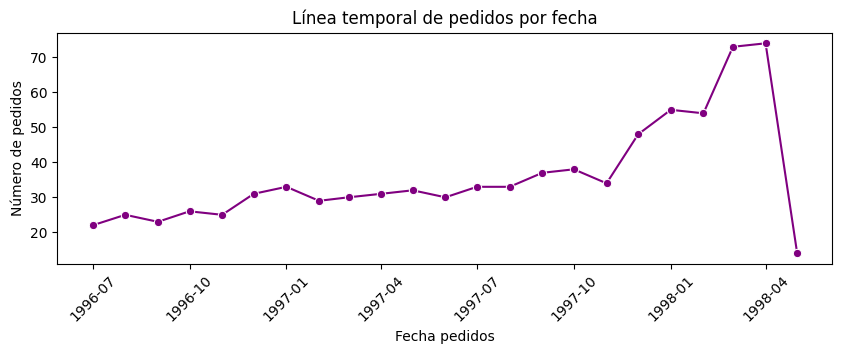

In [10]:
sv.linea_temporal(grouped, 'Date', 'order_count')

- #### Investiga cuáles son los países donde tenemos más ventas. No es necesario realizar una query para obtener el DataFrame. Estudia la distribución de pedidos por continente . Realiza la visualización que creas más conveniente.

In [11]:
df_customers_orders['country'].value_counts()

country
Germany        122
USA            122
Brazil          83
France          78
UK              56
Venezuela       46
Austria         40
Sweden          37
Canada          30
Mexico          28
Italy           28
Spain           24
Finland         22
Ireland         19
Belgium         19
Switzerland     18
Denmark         18
Argentina       16
Portugal        13
Poland           7
Norway           6
Name: count, dtype: int64

In [12]:
continentes = {'Europe': ['Austria',
               'Germany',
               'Ireland',
               'Italy',
               'Norway',
               'Switzerland',
               'UK',
               'Belgium',
               'Poland',
               'Denmark',
               'Portugal',
               'Finland',
               'Spain',
               'France',
               'Sweden'],
               'America': ['Argentina','Brazil','Canada','Mexico','USA','Venezuela'] }

def get_continent(pais):
  for continente, paises in continentes.items():
     if pais in paises:
       return continente
  return None

In [13]:
df_customers_orders['continent'] = df_customers_orders['country'].apply(get_continent)
df_customers_orders.sample(2)

,customer_id,company_name,city,country,order_id,ship_via,order_date,required_date,shipped_date,continent
389,LEHMS,Lehmanns Marktstand,Frankfurt a.M.,Germany,10522.0,1.0,1997-04-30,1997-05-28,1997-05-06,Europe
64,BLONP,Blondesddsl père et fils,Strasbourg,France,10679.0,3.0,1997-09-23,1997-10-21,1997-09-30,Europe


In [20]:
ventas_continent= df_customers_orders['continent'].value_counts()
total_ventas = ventas_continent.sum()
porcent_0 = (ventas_continent.values[0]/total_ventas)*100
porcent_1 = (ventas_continent.values[1]/total_ventas)*100
print(f'El continente {ventas_continent.index[0]} tiene {ventas_continent.values[0]} con un porcentaje {porcent_0}')
print(f'El continente {ventas_continent.index[1]} tiene {ventas_continent.values[1]} con un porcentaje {porcent_1}')

El continente Europe tiene 507 con un porcentaje 60.9375
El continente America tiene 325 con un porcentaje 39.0625


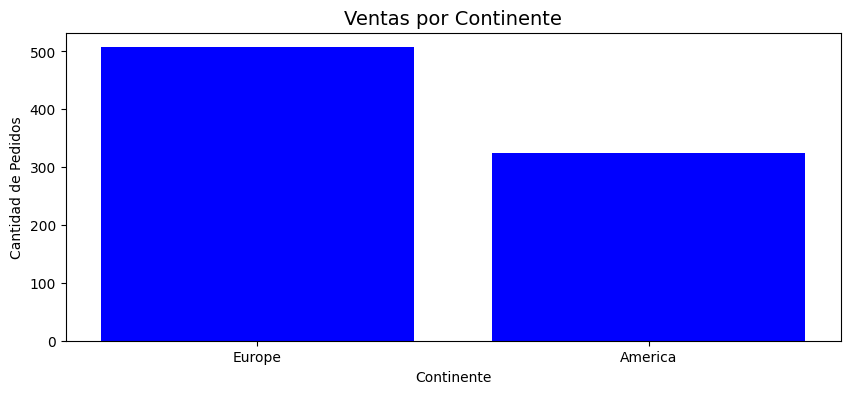

In [ ]:
sv.barras(ventas_continent)

- #### Sabemos que algunos pedidos han llegado con retraso, además hay pedidos que no ha sido registrada su llegada. Investiga si la compañía de transporte está relacionada con ello o no. Realiza un boxplot para ver la diferencia de rango intercuartílico.

In [22]:
df_Shippers = pd.read_csv('../data/shippers.csv')

In [33]:
#calculo un columna para saber los dias que ha tardado el envío
df_customers_orders['days_to_ship'] = (df_customers_orders['shipped_date'] - df_customers_orders['order_date']).dt.days
#calculo un columna para saber si el pedido ha sido retrasado o no se ha enviado
df_customers_orders['delays'] = (df_customers_orders['shipped_date'] > df_customers_orders['required_date']) | (df_customers_orders['shipped_date'].isnull())

In [41]:
df = df_customers_orders.merge(df_Shippers,
                               how='left',
                               left_on='ship_via',
                               right_on='shipper_id'
                               )
df.rename(columns={'company_name_y': 'shipper_company'}, inplace=True)
df

,customer_id,company_name_x,city,country,order_id,ship_via,order_date,required_date,shipped_date,continent,days_to_ship,delays,shipper_id,shipper_company
0,ALFKI,Alfreds Futterkiste,Berlin,Germany,10643.0,1.0,1997-08-25,1997-09-22,1997-09-02,Europe,8.0,False,1.0,Speedy Express
1,ALFKI,Alfreds Futterkiste,Berlin,Germany,10692.0,2.0,1997-10-03,1997-10-31,1997-10-13,Europe,10.0,False,2.0,United Package
2,ALFKI,Alfreds Futterkiste,Berlin,Germany,10702.0,1.0,1997-10-13,1997-11-24,1997-10-21,Europe,8.0,False,1.0,Speedy Express
3,ALFKI,Alfreds Futterkiste,Berlin,Germany,10835.0,3.0,1998-01-15,1998-02-12,1998-01-21,Europe,6.0,False,3.0,Federal Shipping
4,ALFKI,Alfreds Futterkiste,Berlin,Germany,10952.0,1.0,1998-03-16,1998-04-27,1998-03-24,Europe,8.0,False,1.0,Speedy Express
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,WOLZA,Wolski Zajazd,Warszawa,Poland,10792.0,3.0,1997-12-23,1998-01-20,1997-12-31,Europe,8.0,False,3.0,Federal Shipping
828,WOLZA,Wolski Zajazd,Warszawa,Poland,10870.0,3.0,1998-02-04,1998-03-04,1998-02-13,Europe,9.0,False,3.0,Federal Shipping
829,WOLZA,Wolski Zajazd,Warszawa,Poland,10906.0,3.0,1998-02-25,1998-03-11,1998-03-03,Europe,6.0,False,3.0,Federal Shipping
830,WOLZA,Wolski Zajazd,Warszawa,Poland,10998.0,2.0,1998-04-03,1998-04-17,1998-04-17,Europe,14.0,False,2.0,United Package


In [25]:
df_delays = (
    df[df["delays"] == True]  # Filtramos solo los retrasos
    .groupby(["shipper_id", "shipper_company"])["order_id"]
    .count()
    .reset_index()
)
df_delays

,shipper_id,shipper_company,order_id
0,1.0,Speedy Express,16
1,2.0,United Package,27
2,3.0,Federal Shipping,15


In [59]:
total_pedidos = df.shape[0]
df_delays['porcentaje'] = (df_delays['order_id']/ total_pedidos) *100
df_delays

,shipper_id,shipper_company,order_id,porcentaje
0,1.0,Speedy Express,16,1.923077
1,2.0,United Package,27,3.245192
2,3.0,Federal Shipping,15,1.802885


In [ ]:
for _,row in df_delays.iterrows():
        print(f"La compañía {row['shipper_id']} ({row['shipper_company']}) ha tenido {row['order_id']} retrasos.")


La compañía 1.0 (Speedy Express) ha tenido 16 retrasos.
La compañía 2.0 (United Package) ha tenido 27 retrasos.
La compañía 3.0 (Federal Shipping) ha tenido 15 retrasos.


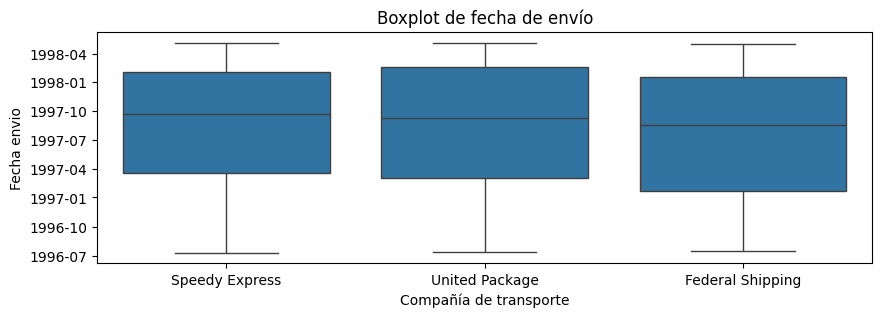

In [ ]:
sv.boxplot(df,'shipper_company', 'shipped_date')

      En base a esto podemos observar que todas las compañias han tenido retrasos, United Pckage ha tenido un poco mas pero no significativamente

- #### Hay bastante diferencia entre el precio pagado en cada pedido. Averigüa la distribución media del precio del pedido por país de procedencia del cliente. Realiza la visualización que creas más conveniente para sacar conclusiones

In [63]:
df_ProductsDT_Suppliers['total_order'] = df_ProductsDT_Suppliers['unit_price_order'] * df_ProductsDT_Suppliers['quantity']
df_ProductsDT_Suppliers.sample()

,product_id,supplier_id,category_id,product_name,unit_price_product,units_in_stock,units_on_order,discontinued,order_id,quantity,unit_price_order,company_name,city,country,total_order
1898,70,7,1,Outback Lager,15.0,15,10,0,10517,6,15.0,"Pavlova, Ltd.",Melbourne,Australia,90.0


In [71]:
df_avg_price= df_ProductsDT_Suppliers.groupby("country").agg({
                                 "total_order":"mean",
                                 "order_id":"count",
                                 "quantity":"sum"}).sort_values(by='total_order', ascending=False)
df_avg_price

,total_order,order_id,quantity
country,,,
France,1674.473164,177,5023
Germany,783.481815,270,6120
Australia,708.899042,261,6045
Canada,644.678723,141,3344
Italy,587.635593,177,4197
Singapore,547.997561,82,1878
Spain,514.784615,52,1050
USA,465.141336,277,6828
Norway,446.640000,105,2526


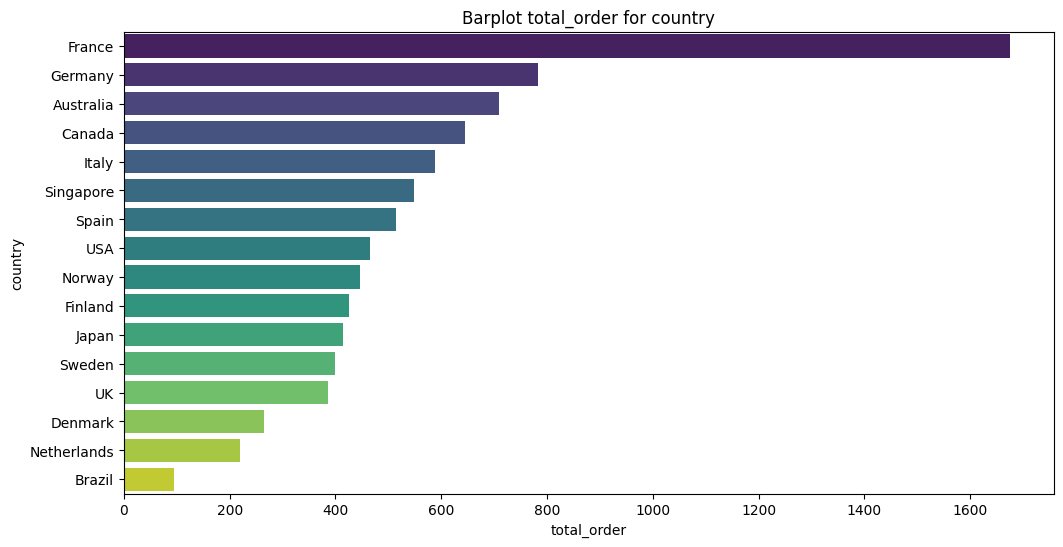

In [65]:
sv.barplot(df_avg_price,'total_order', 'country',"viridis")

        Como se puede ver en la gráfica el precio medio en Francia es mucho más elevado que el resto

- #### Investiga si existen clientes que no hayan pedido nunca. ¿Qué porcentaje de clientes no tienen pedidos registrados?

In [ ]:
order_nulo= round(df["order_id"].isnull().sum()/df["order_id"].shape[0]*100,2)
print(f'El porcentaje de clientes que no han pedido es del {order_nulo} %')

El porcentaje de clientes que no han pedido es del 0.24 %


- #### Estudia los productos más demandados e investiga cuáles corre prisa hacer reestock (Los que quedan 20 o menos y no hay unidades pedidas). Realiza la visualización que creas más conveniente para sacar conclusiones

In [ ]:
df_summary=df_ProductsDT_Suppliers.groupby("product_name").agg({"order_id":"count",
                                                                "quantity": "sum",
                                                                "units_in_stock": "min",
                                                                "units_on_order" : "min",
                                                             }).reset_index().sort_values(by="quantity", ascending=False)
print(f'Los cinco productos más demandados son : \n {df_summary.head(5)["product_name"]}')

Los cinco productos más demandados son : 
 3          Camembert Pierrot
51      Raclette Courdavault
18         Gorgonzola Telino
17    Gnocchi di nonna Alice
46                   Pavlova
Name: product_name, dtype: object


In [ ]:
df_restock = df_summary[(df_summary["units_in_stock"] <= 20) & (df_summary["units_on_order"] == 0)].sort_values(by="units_in_stock", ascending=True)

print("Necesitamos hacer restock de todos estos productos pues quedan menos de 20 unidades y no hay unidades pedidas:") 
df_restock

Necesitamos hacer restock de todos estos productos pues quedan menos de 20 unidades y no hay unidades pedidas:


,product_name,order_id,quantity,units_in_stock,units_on_order
0,Alice Mutton,37,978,0,0
68,Thüringer Rostbratwurst,32,746,0,0
47,Perth Pasties,30,722,0,0
9,Chef Anton's Gumbo Mix,10,298,0,0
42,Northwoods Cranberry Sauce,13,372,6,0
41,Nord-Ost Matjeshering,32,612,10,0
40,Mozzarella di Giovanni,38,806,14,0
72,Uncle Bob's Organic Dried Pears,29,763,15,0
24,Gumbär Gummibärchen,32,753,15,0
66,Tarte au sucre,48,1083,17,0


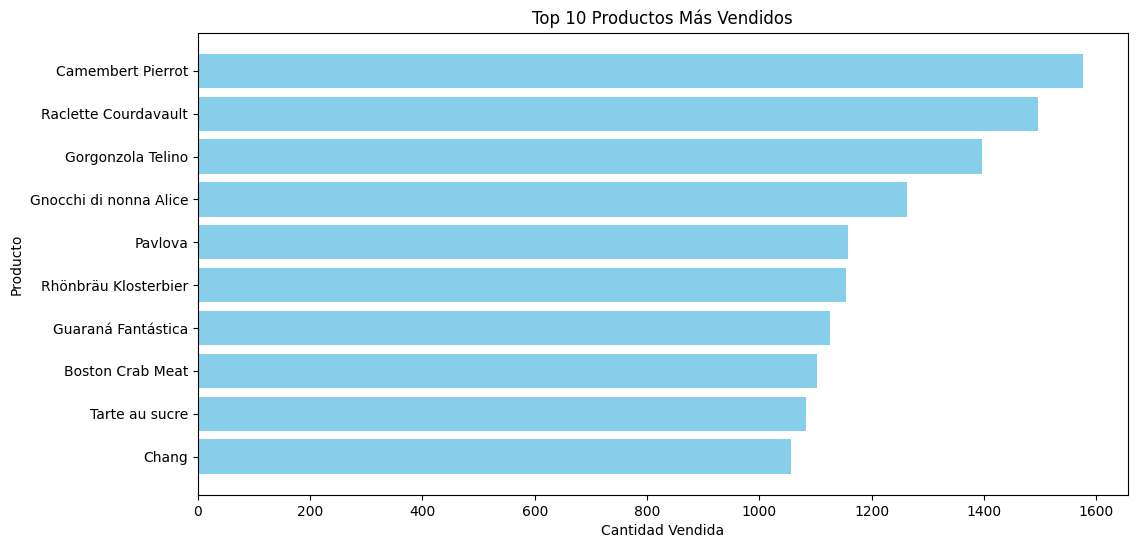

In [ ]:
top_10= df_summary.head(10)
sv.barh(top_10["product_name"], top_10['quantity'],'skyblue')

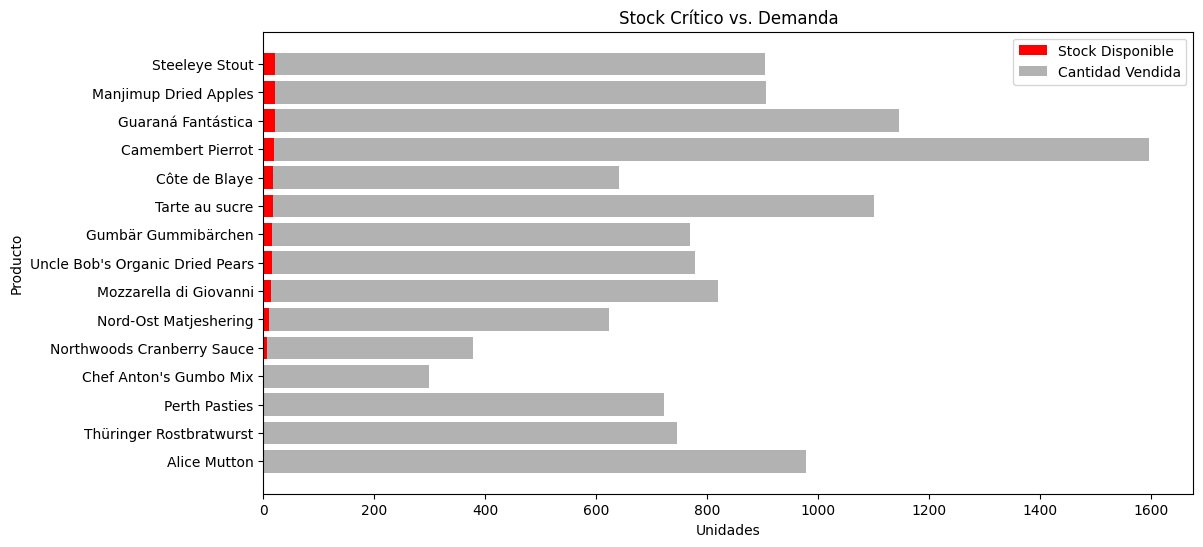

In [ ]:
sv.plot_barh_dual(df_restock["product_name"], df_restock["units_in_stock"], df_restock["quantity"],)

In [ ]:
print(f'Tenemos {df_restock["product_name"].count()} productos que necesitan reabastecerse y como podemos ver en los graficos son bastante demandados por lo que hay que hacerlo pronto')

Tenemos 15 productos que necesitan reabastecerse y como podemos ver en los graficos son bastante demandados por lo que hay que hacerlo pronto


In [ ]:
df_ProductsDT_Suppliers.to_csv('../data/details_prod_supl.csv', index=False)
df_customers_orders.to_csv('../data/customers_orders.csv', index=False)